### Polinomial fit

$$
f(x)=3x^3-2x^2-3x+4
$$

Proviamo a fittare un polinomio di ordine 3 per $x \in [-1,1]$.

In [8]:
# f(x) = ax^3 + bx^2 + cx + d
a = 3
b = -2
c = -3
d = 4

def f(x):
        return a*x**3 + b*x**2 + c*x + d

Parametri generici:

In [9]:
n_train = 5000
sigma = 0.4 # noise standard deviation
n_epochs = 30

Generiamo i punti nel piano cartesiano che costituiranno il **training set** e il **validation set**.

In [10]:
import numpy as np

n_valid = int(n_train/10)   # tipically the majority of the data is partitioned into the training set.

# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, n_train)
x_valid = np.random.uniform(-1, 1, n_valid)
x_valid.sort()
y_target = f(x_valid) # ideal (target) linear function

y_train = np.random.normal(f(x_train), sigma) 
y_valid = np.random.normal(f(x_valid), sigma)

Grafici del training set e del validation set rispetto al polinomio che stiamo considerando.

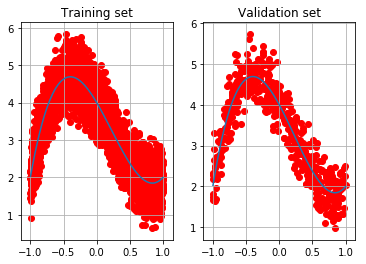

In [11]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(1,2)

axarr[0].plot(x_valid, y_target)
axarr[0].scatter(x_train, y_train, color='r')
axarr[0].grid(True); 
axarr[0].set_title('Training set')

axarr[1].plot(x_valid, y_target)
axarr[1].scatter(x_valid, y_valid, color='r')
axarr[1].grid(True); 
axarr[1].set_title('Validation set')

plt.show()

Gli optimizers più utilizzati sono:

In [12]:
from tensorflow import keras

sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adag = keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
adad = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

### Tentativo 1
Partiamo dal caso più semplice: costruiamo una rete con un hidden layer composto da 2 neuroni senza attivazione.

In [13]:
import tensorflow as tf


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model_1 = tf.keras.Sequential()
model_1.add(Dense(2, input_shape=(1,)))
model_1.add(Dense(1))

# compile the model choosing optimizer, loss and metrics objects
model_1.compile(optimizer=sgd, loss='mse', metrics=['mse'])

W0711 12:31:43.830243 4631029184 deprecation.py:506] From /usr/local/intel/intelpython3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 4         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


Training della rete:

In [15]:
history = model_1.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=n_epochs,
          shuffle=True, 
          validation_data=(x_valid, y_valid))

Train on 5000 samples, validate on 500 samples
Epoch 1/30
5000/5000 [==============================] - 0s 40us/sample - loss: 0.9904 - mean_squared_error: 0.9904 - val_loss: 0.7671 - val_mean_squared_error: 0.7671
Epoch 2/30
5000/5000 [==============================] - 0s 24us/sample - loss: 0.7467 - mean_squared_error: 0.7467 - val_loss: 0.7660 - val_mean_squared_error: 0.7660
Epoch 3/30
5000/5000 [==============================] - 0s 24us/sample - loss: 0.7510 - mean_squared_error: 0.7510 - val_loss: 0.7795 - val_mean_squared_error: 0.7795
Epoch 4/30
5000/5000 [==============================] - 0s 24us/sample - loss: 0.7515 - mean_squared_error: 0.7515 - val_loss: 0.7638 - val_mean_squared_error: 0.7638
Epoch 5/30
5000/5000 [==============================] - 0s 25us/sample - loss: 0.7510 - mean_squared_error: 0.7510 - val_loss: 0.7671 - val_mean_squared_error: 0.7671
Epoch 6/30
5000/5000 [==============================] - 0s 23us/sample - loss: 0.7496 - mean_squared_error: 0.7496 - v

In [16]:
model_1.get_weights()

[array([[-1.2836565 , -0.01608715]], dtype=float32),
 array([0.5022129 , 0.24471287], dtype=float32),
 array([[0.9704015],
        [0.1361948]], dtype=float32),
 array([2.7096398], dtype=float32)]

In [17]:
# evaluate model
score = model_1.evaluate(x_valid, y_valid, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

500/500 [==============================] - 0s 21us/sample - loss: 0.7719 - mean_squared_error: 0.7719

Test loss: 0.7718656845092774
Test accuracy: 0.7718656


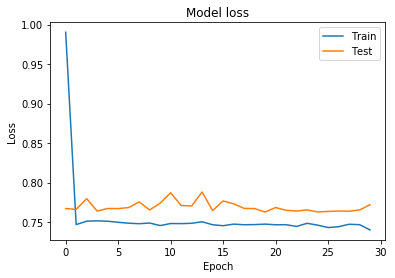

In [18]:
# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

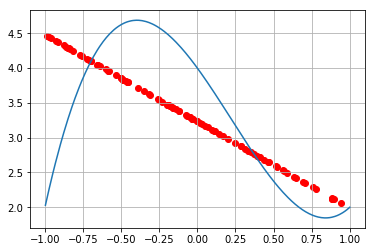

In [30]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model_1.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

Questa rete è troppo semplice e non è in grado di fittare il polinomio di grado 3. Proviamo ad aggiungere neuroni e una funzione di attivazione.

### Tentativo 2
Aumentiamo il numero di neuroni mantenendo un solo hidden layer. E' necessario introdurre qualche effetto di non linearità. Utilizziamo una funzione di attivazione tipica: ReLu.

In [1]:
model_2 = tf.keras.Sequential()
model_2.add(Dense(30, input_shape=(1,), activation='relu'))
model_2.add(Dense(1))

# compile the model choosing optimizer, loss and metrics objects
model_2.compile(optimizer=sgd, loss='mse', metrics=['mse'])

history = model_2.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=n_epochs,
          shuffle=True, 
          validation_data=(x_valid, y_valid))

NameError: name 'tf' is not defined

In [ ]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model_2.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

### Tentativo 3
Aumentiamo il numero di layer.

In [25]:
model_3 = tf.keras.Sequential()
model_3.add(Dense(30, input_shape=(1,)))
model_3.add(Dense(30, activation='relu'))
model_3.add(Dense(30, activation='relu'))
model_3.add(Dense(1, activation='relu'))

# compile the model choosing optimizer, loss and metrics objects
model_3.compile(optimizer=adag, loss='mse', metrics=['mse'])

history = model_3.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=n_epochs,
          shuffle=True, 
          validation_data=(x_valid, y_valid))

Train on 5000 samples, validate on 500 samples
Epoch 1/30
5000/5000 [==============================] - 0s 48us/sample - loss: 1.4375 - mean_squared_error: 1.4375 - val_loss: 0.5001 - val_mean_squared_error: 0.5001
Epoch 2/30
5000/5000 [==============================] - 0s 30us/sample - loss: 0.3470 - mean_squared_error: 0.3470 - val_loss: 0.2851 - val_mean_squared_error: 0.2851
Epoch 3/30
5000/5000 [==============================] - 0s 29us/sample - loss: 0.2326 - mean_squared_error: 0.2326 - val_loss: 0.2157 - val_mean_squared_error: 0.2157
Epoch 4/30
5000/5000 [==============================] - 0s 28us/sample - loss: 0.1978 - mean_squared_error: 0.1978 - val_loss: 0.2004 - val_mean_squared_error: 0.2004
Epoch 5/30
5000/5000 [==============================] - 0s 27us/sample - loss: 0.1863 - mean_squared_error: 0.1863 - val_loss: 0.1834 - val_mean_squared_error: 0.1834
Epoch 6/30
5000/5000 [==============================] - 0s 27us/sample - loss: 0.1790 - mean_squared_error: 0.1790 - v

In [26]:
# evaluate model
score = model_3.evaluate(x_valid, y_valid, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

500/500 [==============================] - 0s 36us/sample - loss: 0.1555 - mean_squared_error: 0.1555

Test loss: 0.15550363278388976
Test accuracy: 0.15550365


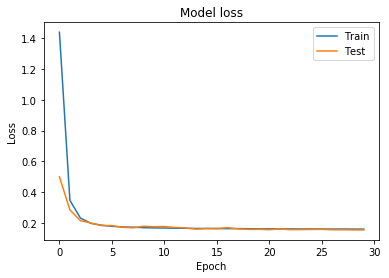

In [27]:
# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

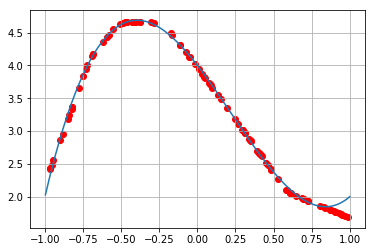

In [28]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model_3.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

Il risultato è soddisfacente per tutti e tre gli optimizer elencati in precedenza. Qui abbiamo usato in particolare Adagrad, che sembra produrre un risultato leggermente più accurato.

Testiamo la rete appena creata su nuovi set di dati, che include punti fuori dal range di partenza $[-1,1]$.

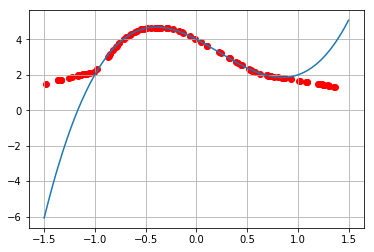

In [29]:
x = np.random.uniform(-1.5, 1.5, n_valid)
x.sort()

x_predicted = np.random.uniform(-1.5, 1.5, 100)
y_predicted = model_3.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x, a*x**3 + b*x**2 + c*x + d)
plt.grid(True)
plt.show()

Notiamo che la rete ha buon potere predittivo solo nel range in cui è stata allenata.

Summarize....?????